## Figure 2cd: Drug combination associations with host and microbiome

This script prints Figure 2cd: **c. Additive effects of drug combinations in T2D patient group.** The heatmap shows the number of features (separated into host and microbiome) that are affected by the drug combination more strongly than by single drugs in T2D group. The values on the diagonal correspond to the number of features affected by the single drug in T2D group. All features are deconfounded, and drug associations are discordant with the disease effect and significant (two-sided MWU FDR < 0.1).

**d. Selected supra-additive combination effects.** Figure shows effect size (Cliff’s delta) and direction of disease associations (T2D, red), individual drug effects (other colours) and effects of the drug combinations (black) in T2D group for the combination of statin and metformin, statin and aspirin, and statin and calcium antagonist. 

Specifically, the features are shown if 1) effect of the drug combination is significant (MWU FDR < 0.1) and passes all confounder filters, 2) disease association is opposite in direction to that of the drug combination and 3) the combination additionally achieves significance in a nested linear model comparison test (likelihood ratio post-hoc P < 0.05) for supra-additivity, that is, the combination offers predictive capacity beyond the individual drugs all included as separate predictors. 

Each  line on the vertical axis corresponds to one feature – drug combination pair. 

Required file in the *input_data* folder:

- Supplementary_Table_6_2019-09-13434.xlsx

Supplementary Table 6: Features of microbiome, host and metabolome impacted by different drug groups and drug compounds. Results of drug group (or drug compound according to the ATC classification) assessment for its impact on host and microbiome features for each patient group. Compound comparison with Maier et al., Nature 2018, tab shows microbiome features negatively impacted by the drug treatment (for the ATC-level compounds) in at least one patient group, and bacterial species whose growth was inhibited by the same drug in the in vitro experiment.

- Supplementary_Table_8_2019-09-13434.xlsx

Supplementary Table 8: Features of microbiome, host and metabolome impacted by different drug combinations. Analysis of the effect of drug combinations, assessed for impact on host and microbiome falling within different measurement categories in each patient group. 

- group_T2D_associations.txt

File containing all associations between drugs and features in T2D group (both significant and non-significant). 

Figure is based on the data from Supplementary Tables 6 and 8. 

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.tri import Triangulation
%matplotlib inline

In [2]:
# read single drug features files
fileFolder = './input_data/'
fileName = 'Supplementary_Table_6_2019-09-13434.xlsx'
sheetName = 'Drug group effect'
drugEffect = pd.read_excel(fileFolder + fileName,
                           sheet_name = sheetName)

In [3]:
# Extract features associated with the drugs 
# in direction opposite from the disease effect
drugIntakedata_opposite = drugEffect[drugEffect['Congruence']==
                                                 'Opposite'].copy()

In [4]:
# read drug combination features files
fileName = 'Supplementary_Table_8_2019-09-13434.xlsx'
sheetName = 'Data'
drugCombinationEffect = pd.read_excel(fileFolder + fileName,
                           sheet_name = sheetName)

In [5]:
# Extract features associated with the drugs 
# in direction opposite from the disease effect
drugCombodata = drugCombinationEffect[drugCombinationEffect['Congruence']==
                                                            'Opposite'].copy()

In [6]:
# Get conditions (patient groups)
conditions = list(set(drugCombodata['Sample set']))
# get drug combinations
DrugCombo_columns = [item for item in drugCombodata.columns 
                     if ('Effector' in item) and not('ID' in item)]
DrugCombo = []
for item in DrugCombo_columns:
    if len(DrugCombo)==0:
        DrugCombo = set(drugCombodata[item])
    else:
        DrugCombo = DrugCombo.union(drugCombodata[item]) 
DrugCombo = [item for item in DrugCombo if type(item)==str]
DrugCombo.sort()

In [7]:
# Extract feature spaces to group features
Feature_space_columns = [item for item in drugCombodata.columns if 'Feature space' in item]
Feature_space = []
for item in Feature_space_columns:
    if len(Feature_space)==0:
        Feature_space = set(drugCombodata[item])
    else:
        Feature_space = Feature_space.union(drugCombodata[item]) 
Feature_space = [item for item in Feature_space if type(item)==str]
Feature_space.sort()

Plot features associated with drug combinations per patient group

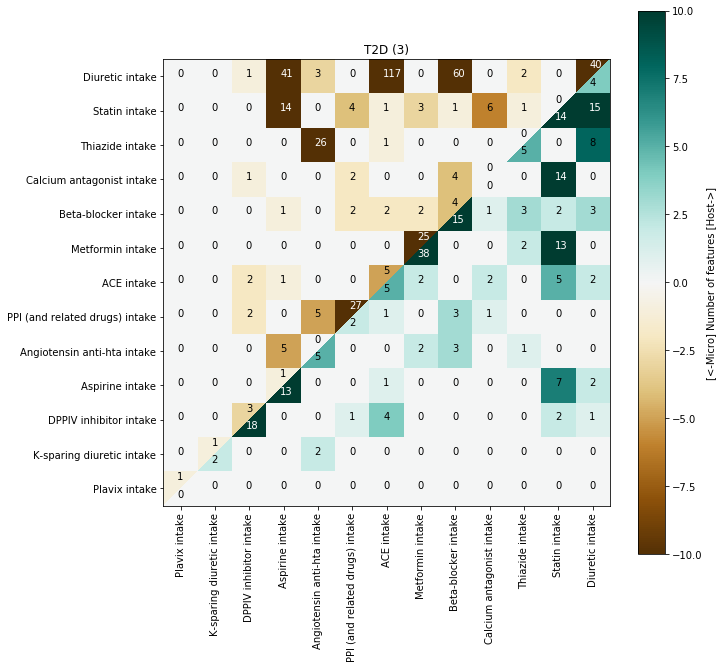

In [8]:
# change [conditions[select_cond]] to 'conditions' to plot the figures for each patient group
select_cond = conditions.index('T2D (3)')
for curcond in [conditions[select_cond]]:
    DrugCombo_FeatureSpace_df = pd.DataFrame(0, index = DrugCombo, columns = Feature_space)
    for curcombo in DrugCombo:
        for curfeature in Feature_space:
            DrugCombo_FeatureSpace_df.loc[curcombo, curfeature] = \
                DrugCombo_FeatureSpace_df.loc[curcombo, curfeature] + \
                len(drugCombodata[(drugCombodata['Feature space']==curfeature) &
                                  (drugCombodata['Sample set']==curcond) &
                                  (drugCombodata['Effector']==curcombo)])
    drugs_from_combo = [item.split(',') for item in DrugCombo]
    drugs_from_combo = [x for y in drugs_from_combo for x in y]
    drugs_from_combo = [item.replace('Combination: ', '') for item in drugs_from_combo]
    drugs_from_combo = [item.strip() for item in drugs_from_combo]
    drugs_from_combo = list(set(drugs_from_combo))        
    
    # calculate single drug features for condition
    # calculate number of features affected by each drug
    drugIntakedata_opposite_df = pd.DataFrame(0, index = drugs_from_combo,
                                             columns = ['Met', 'Micro'])

    # create drug-drug feature matrix for current patient group
    DrugDrug_FeatureSpace_df = pd.DataFrame(0, 
                                    index = sorted(drugs_from_combo),
                                    columns = sorted(drugs_from_combo))

    columns_met = [item for item in DrugCombo_FeatureSpace_df.columns
                   if ('Serum' in item) or ('Urine' in item) or 
                   ('Pheno' in item)]
    columns_micro = [item for item in DrugCombo_FeatureSpace_df.columns
                   if ('modules' in item) or ('MGS' in item) or 
                     ('mOTU' in item) or ('Alpha' in item)]

    for curdrug in drugs_from_combo:
        curfeatures = drugIntakedata_opposite[
                    (drugIntakedata_opposite['Effector']==curdrug) &
                    (drugIntakedata_opposite['Sample set']==curcond)]
        curfeatures = curfeatures['Feature space']
        nummet = len([item for item in curfeatures if item in columns_met])
        nummicro=len([item for item in curfeatures if item in columns_micro])
        drugIntakedata_opposite_df.loc[curdrug, 'Met'] = nummet
        drugIntakedata_opposite_df.loc[curdrug, 'Micro'] = nummicro
    

    for item in DrugCombo_FeatureSpace_df.index:
        curdrugs = item.split(',')
        curdrugs = [item.replace('Combination: ', '') for item in curdrugs]
        curdrugs = [item.strip() for item in curdrugs]
        curdrugs = sorted(curdrugs)
        DrugDrug_FeatureSpace_df.loc[curdrugs[0], curdrugs[1]] = \
            DrugCombo_FeatureSpace_df.loc[item, columns_met].sum()
        DrugDrug_FeatureSpace_df.loc[curdrugs[1], curdrugs[0]] = \
            DrugCombo_FeatureSpace_df.loc[item, columns_micro].sum()

    plotdata = (DrugDrug_FeatureSpace_df)

    sortidx = np.argsort(plotdata.sum(axis=1))


    plotdata = plotdata.iloc[sortidx, sortidx]

    plotdata  = plotdata * (np.tril(-1*np.ones(len(drugs_from_combo))) + 
                            np.triu(np.ones(len(drugs_from_combo))))


    drugmet = np.asarray([drugIntakedata_opposite_df.loc[item,'Met'] 
               if item in drugIntakedata_opposite_df.index else 0
               for item in plotdata.index])
    drugmicro = np.asarray([drugIntakedata_opposite_df.loc[item,'Micro'] 
               if item in drugIntakedata_opposite_df.index else 0
               for item in plotdata.index])

    colormax=10
    fig = plt.figure(figsize=(10, 10))

    M = np.shape(plotdata)[0]
    N = np.shape(plotdata)[1]
    x = np.arange(M+1)
    y = np.arange(N+1)
    xs, ys = np.meshgrid(x, y)
    zs = np.asarray(plotdata) + np.diag(-drugmicro)#xs * ys) % 10 #np.asarray(plotdata)#
    zs = zs.ravel()#zs[:-1, :-1].ravel()
    zs2 = np.asarray(plotdata) + np.diag(drugmet)
    zs2 = zs2.ravel()

    triangles1 = [(i + j*(M+1), i + (j+1)*(M+1), (i+1) + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i + j*(M+1), i+1 + j*(M+1), (i+1) + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
    triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)
    img1 = plt.tripcolor(triang1, zs, cmap='BrBG', vmin=-colormax,vmax=colormax)
    img2 = plt.tripcolor(triang2, zs2, cmap='BrBG', vmin=-colormax,vmax=colormax)

    clb = plt.colorbar(img1)
    clb.ax.set_ylabel('[<-Micro] Number of features [Host->]')
    plt.xlim(x[0]-0.5, x[-1]-0.5)
    plt.ylim(y[0]-0.5, y[-1]-0.5)
    plt.xticks(x[:-1], plotdata.index, rotation=90)
    plt.yticks(y[:-1],plotdata.index)
    plt.title(curcond)

    # add text
    for i in range(np.shape(xs)[0]-1):
        for j in range(np.shape(xs)[1]-1):
            if i==j:
                movetext=0
            else:
                movetext=-0.25
            if int(np.abs(zs[i*(np.shape(xs)[0]-1)+j]))>=10:
                plt.text(xs[i][j]-0.1, ys[i][j]+0.25+movetext, 
                     int(np.abs(zs[i*(np.shape(xs)[0]-1)+j])), color='white');
            else:
                plt.text(xs[i][j]-0.1, ys[i][j]+0.25+movetext, 
                     int(np.abs(zs[i*(np.shape(xs)[0]-1)+j])));    
    for i in range(np.shape(xs)[0]-1):
        if int(zs2[i*(np.shape(xs)[0]-1)+i])>=10:
            plt.text(xs[i][i]-0.1, ys[i][i]-0.25, int(zs2[i*(np.shape(xs)[0]-1)+i]),color='white');
        else:
            plt.text(xs[i][i]-0.1, ys[i][i]-0.25, int(zs2[i*(np.shape(xs)[0]-1)+i]));

    ax = plt.gca()
    ax.set_aspect('equal')
    plt.rcParams['svg.fonttype'] = 'none'
    filename = "Fig2c_heatmap_features_in_drug_combinations_" + curcond
# UNCOMMENT TO SAVE TO FILE
#     fig.savefig(filename + '.png',
#                 format='png',
#                 bbox_inches='tight')
#     fig.savefig(filename + '.svg',
#                 format='svg',
#                 bbox_inches='tight')

## Plot selected feature-drug combinations

In [9]:
fileName = 'group_T2D_associations.txt'
allEffects_df = pd.read_csv(fileFolder + fileName, sep='\t', header=0, low_memory=False)

In [10]:
allEffects_df.iloc[0:3,:]

,Effector,Test,Sample set,Feature space,Feature display name,FDR,Effect size,Confounder status,Feature ID,Effector ID,Feature class,Comparison to controls,Congruence,Posthoc P,Comparison Q,Comparison D,Comparison status
0,"Combination: ACE intake, Aspirine intake",Drug combination effect,T2D (3),GMM modules,ribose degradation (MF0020),0.987466,0.029601,NS,FunctionAdjustedID.GMM.down.10000000.v5.1,COMB_ACE_INHIB_C_ASA_C,Microbiome function,Depleted in T2D (3),Opposite,NaN,0.036436,-0.095031,"COMB_THIAZIDIQUE_C_AT2_INHIB_C, BMI_C, COMB_AC..."
1,"Combination: ACE intake, Calcium antagonist in...",Drug combination effect,T2D (3),GMM modules,ribose degradation (MF0020),0.938164,0.040079,NS,FunctionAdjustedID.GMM.down.10000000.v5.1,COMB_ACE_INHIB_C_CA2_CBL_C,Microbiome function,Depleted in T2D (3),Opposite,NaN,0.036436,-0.095031,"COMB_THIAZIDIQUE_C_AT2_INHIB_C, BMI_C, COMB_AC..."
2,"Combination: ACE intake, Metformin intake",Drug combination effect,T2D (3),GMM modules,ribose degradation (MF0020),0.456756,-0.079413,NS,FunctionAdjustedID.GMM.down.10000000.v5.1,COMB_ACE_INHIB_C_METFORMIN_C,Microbiome function,Depleted in T2D (3),Same,NaN,0.036436,-0.095031,"COMB_THIAZIDIQUE_C_AT2_INHIB_C, BMI_C, COMB_AC..."


In [11]:
allEffects_df = allEffects_df.drop_duplicates()

In [12]:
sample_effector_unique = list(set(allEffects_df['Effector']))
sample_effector_unique = [item for item in sample_effector_unique
                         if type(item)==str]

In [13]:
curgroup = 'Controls (8) vs T2D (3)'
curgroup_df = allEffects_df[(allEffects_df['Sample set']==curgroup)].copy()

In [14]:
cureffectors_pairs = [['Statin intake', 'Metformin intake'],
                      ['Statin intake', 'Calcium antagonist intake'],
                      ['Statin intake', 'Aspirine intake']]
curset = 'T2D (3)'
plotdata_combined = []
plotdata_combined_drug1 = []
plotdata_combined_drug2 = []

for cureffectors in cureffectors_pairs:
    selectedEffectd_df = allEffects_df[
        ((allEffects_df['Effector']==cureffectors[0]) |
         (allEffects_df['Effector']==cureffectors[1])) &
         (allEffects_df['Sample set']==curset)].copy()
    cureffectors_df_significant = []
    for cureffect in cureffectors:
        cureffect_df = selectedEffectd_df[
            (selectedEffectd_df['Effector']==cureffect) &
            (selectedEffectd_df['Sample set']==curset)].copy()

        cureffect_df_significant = cureffect_df[cureffect_df['FDR']<=0.1].copy()

        cureffect_df_significant = cureffect_df_significant[
            (cureffect_df_significant['Confounder status']=='SD') |
            (cureffect_df_significant['Confounder status']=='LD')]
        if len(cureffectors_df_significant)==0:
            cureffectors_df_significant = cureffect_df_significant.copy()
        else:
            cureffectors_df_significant = pd.concat(
                [cureffectors_df_significant,cureffect_df_significant])  
        # get combination features
        curcombo = [item for item in sample_effector_unique if type(item)==str]
        curcombo = [item for item in curcombo
                   if (cureffectors[0] in item) & (cureffectors[1] in item) &
                   (item.count('intake')==2)][0] #only pairs

        cureffect_df = allEffects_df[(allEffects_df['Effector']==curcombo) &
                                  (allEffects_df['Sample set']==curset)].copy()
        
        # combine all single and all combo
        selectedEffectd_df = pd.concat([selectedEffectd_df, cureffect_df])
        selectedEffectd_df = selectedEffectd_df.drop_duplicates()
        
        cureffect_df_significant = cureffect_df[cureffect_df['FDR']<=0.1].copy()
        cureffect_df_significant = cureffect_df_significant[
            cureffect_df_significant['Posthoc P']<=0.05]

        cureffect_df_significant = cureffect_df_significant[
            cureffect_df_significant['Congruence']=='Opposite']

        cureffect_df_significant = cureffect_df_significant[
            (cureffect_df_significant['Confounder status']=='SD') |
            (cureffect_df_significant['Confounder status']=='LD')]
        
        if len(cureffectors_df_significant)==0:
            cureffectors_df_significant = cureffect_df_significant.copy()
        else:
            cureffectors_df_significant = pd.concat(
                [cureffectors_df_significant,cureffect_df_significant])    

        features_combined = cureffect_df_significant['Feature space'] + \
                             '_' + \
                            cureffect_df_significant['Feature display name']
        features_combined = list(set(features_combined))

        features_combined_space = [item[0:item.find('_')] 
                                   for item in features_combined]
        features_combined_features = [item[item.find('_')+1:] 
                                   for item in features_combined]

        features_combined_columns = cureffectors.copy()
        features_combined_columns.append(curcombo)

        feature_effect_df = pd.DataFrame(0, index = features_combined,
                                        columns = features_combined_columns)
        feature_effectFDR_df = pd.DataFrame(0, index = features_combined,
                                        columns = features_combined_columns)

    for i in range(len(features_combined)):
        for cureffect in features_combined_columns:
            cureffect_df = selectedEffectd_df[
                (selectedEffectd_df['Effector']==cureffect)
                                    &
                (selectedEffectd_df['Sample set']==curset)
                                    &
            (selectedEffectd_df['Feature space']==features_combined_space[i])
                                 &
    (selectedEffectd_df['Feature display name']==features_combined_features[i])
                                ]

            # add to dataframe
            feature_effect_df.loc[features_combined[i],cureffect]=\
                cureffect_df['Effect size'].values
            feature_effectFDR_df.loc[features_combined[i],cureffect]=\
                cureffect_df['FDR'].values

    disease_effect = []
    for i in range(len(features_combined)):
        cureffect_df = curgroup_df[
        (curgroup_df['Feature space']==features_combined_space[i])
                             &
        (curgroup_df['Feature display name']==features_combined_features[i])]
        disease_effect.append(cureffect_df['Effect size'].values[0])

    feature_effect_df[curgroup] = disease_effect

    plotdata = feature_effect_df.copy()
    plotdata = plotdata[plotdata[curcombo]*plotdata[curgroup]<0]

    plotdata['Type'] = ['Host' if ('Serum' in plotdata.index[i]) or 
                                  ('Urine' in plotdata.index[i]) or
                                  ('Phenotype' in plotdata.index[i])
                        else 'Micro'
                        for i in range(len(plotdata.index))]
    # save drug for colored plotting
    plotdata_combined_drug1.extend([plotdata.columns[0]]*plotdata.shape[0]) 
    plotdata_combined_drug2.extend([plotdata.columns[1]]*plotdata.shape[0]) 
    plotdata.columns = ['Drug1','Drug2','DrugCombo','Disease','Type']
    if len(plotdata_combined)==0:
        plotdata_combined = plotdata.copy()
    else:
        plotdata_combined = pd.concat([plotdata_combined,plotdata])
    #print(len(plotdata))

Prepare dataframe to plot. 

In [15]:
plotdata = plotdata_combined.copy()

# save index of each record in column Numbers 
plotdata['Numbers'] = range(len(plotdata))

# sort by type and disease
plotdata = plotdata.sort_values(by=['Type','Disease'])
plotdata = plotdata.drop(columns='Type')

plotdata = plotdata.sort_values(by='Disease')

plotdata_drug1 = [plotdata_combined_drug1[i] for i in plotdata['Numbers']]
plotdata_drug2 = [plotdata_combined_drug2[i] for i in plotdata['Numbers']]

# remove Numbers column
plotdata = plotdata.drop(columns='Numbers')

In [16]:
plotcolors = {'Statin intake': '#f0e442',
              'Metformin intake': '#009e73',
              'Calcium antagonist intake': '#d55e00',
              'Aspirine intake': '#e69f00'}

In [17]:
mycolors = [[plotcolors[i] for i in plotdata_drug1],
            [plotcolors[i] for i in plotdata_drug2],
            'k', 'r']

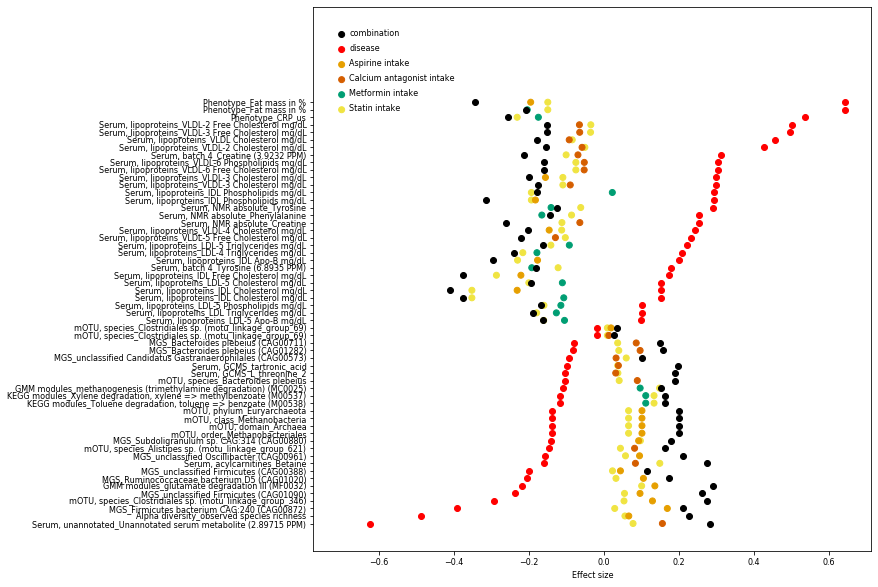

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 8})
coli = 0
for curcol in plotdata.columns:
    plt.scatter(plotdata[curcol], range(len(plotdata[curcol])),
               color = mycolors[coli])
    coli = coli+1
plt.yticks(range(len(plotdata.index)),plotdata.index);
plt.xlabel('Effect size')
plt.rcParams['svg.fonttype'] = 'none'
plt.scatter([-0.7]*6, range(55,66,2),c=list(plotcolors.values())+['r','k'])
legendtext = list(plotcolors.keys())+['disease','combination']
for i in range(6):
    plt.text(-0.68, 55+i*2-0.2,legendtext[i])
         
# UNCOMMENT TO SAVE FIGURE TO FILE
# filename = "Fig2d_feature_effects_combined_statin_metformin_aspirin_CCB"
# fig.savefig(fileFolder + filename + '.png',
#             format='png',
#             bbox_inches='tight')
# fig.savefig(fileFolder + filename + '.svg',
#             format='svg',
#             bbox_inches='tight')

In [19]:
import pkg_resources
import sys

#print package versions
print('Sesssion info:')
print('Python: ', sys.version)
print('numpy: ', pkg_resources.get_distribution('numpy').version)
print('pandas: ', pkg_resources.get_distribution('pandas').version)
print('matplotlib: ', pkg_resources.get_distribution('matplotlib').version)
print('seaborn: ', pkg_resources.get_distribution('seaborn').version)

Sesssion info:
Python:  3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
numpy:  1.18.1
pandas:  1.0.3
matplotlib:  3.1.3
seaborn:  0.10.0
